In [1]:
import numpy as np
import math 
from sympy import *
from sympy.abc import x,y,X,Y
import random
import operator
import sys
import pandas as pd
import pickle
import plotly.express as px
# %load_ext memory_profiler
from sympy import Symbol 
from sympy import MatrixSymbol, Matrix
from collections import deque
PRECISION = 6
from multiprocessing import Pool
from functools import partial
import tqdm
import time
import string
import json
from matplotlib import pyplot as plt

In [2]:
def bin_dec(s):
    d = 0 
    for i in range(len(s)):
        d += int(s[i])*(2**(len(s)-i-1))
    return d 

def kappa(m):
    s = ""
    for i in range(m):
        s += str(i%2)
    return s 

def bin_space_gen(d):
    all_coeff = {}
    for i in range(0,2**(d)): 
        t = i
        all_coeff[i] = ""
        for j in range (0,d):
            all_coeff[i]= str(t%2)+all_coeff[i]
            t = int(t/2)
    return all_coeff

def valid(vect,COUNT):
    cnt = 0
    for i in range(0,len(vect)):
        if vect[i] == "1":
            cnt+=1
    if(cnt == COUNT) :
        return 1 
    else :
        return 0
    
def count(a, b):
    m = len(a)
    n = len(b)
 
    lookup = [[0] * (n + 1) for i in range(m + 1)]
 
    # If first string is empty
    for i in range(n+1):
        lookup[0][i] = 0
 
    # If second string is empty
    for i in range(m + 1):
        lookup[i][0] = 1
 
    # Fill lookup[][] in bottom up manner
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if a[i - 1] == b[j - 1]:
                lookup[i][j] = lookup[i - 1][j - 1] + lookup[i - 1][j]     
            else:
                # If last character are different, ignore last character of first string
                lookup[i][j] = lookup[i - 1][j]
 
    return lookup[m][n]

def size_ins_ball(n_temp,m_temp):
    temp = 0
    for r in range(m_temp,n_temp+1):
        temp += math.comb(n_temp,r)
    return temp

In [3]:
def edit_dis(str1, str2, m, n):
    if m == 0:
        return n
    if n == 0:
        return m
 
    if str1[m-1] == str2[n-1]:
        return edit_dis(str1, str2, m-1, n-1)
 

    return 1 + min(edit_dis(str1, str2, m, n-1),    # Insert
                   edit_dis(str1, str2, m-1, n),    # Remove
                   edit_dis(str1, str2, m-1, n-1)    # Replace
                  )

In [4]:
def choose(n, k):
    """
    A fast way to calculate binomial coefficients by Andrew Dalke (contrib).
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [5]:
def add_node(nodes,parent_stack,s,n_temp, m_temp, parent):
    # print(s,n_temp, m_temp, parent)
    # print(nodes)
    # print(parent_stack)
    if(n_temp>0 and n_temp!=m_temp and m_temp>0):
        if(s=="l"):
            if(m_temp-1>=0): 
                parent_stack.append(len(parent_stack))
                nodes.append((len(nodes),n_temp,m_temp,parent,s))
                temp = nodes[len(nodes)-1][0]
                add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, temp)
                add_node(nodes,parent_stack,"r",n_temp-1, m_temp,temp)
                
        elif(s=="r"):
            parent_stack.append(len(parent_stack))
            nodes.append((len(nodes),n_temp,m_temp,parent,s))
            temp = nodes[len(nodes)-1][0]
            add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, temp)
            add_node(nodes,parent_stack,"r",n_temp-1, m_temp, temp)
        parent_stack.pop()
        
    elif(n_temp==m_temp or m_temp==0):
        nodes.append((len(nodes),n_temp,m_temp,parent,s))

In [6]:
def list_to_str(lst):
    strn =""
    for i in range(len(lst)):
        strn = strn+str(lst[i])
    return strn

def wlogw(wt):
    return wt*math.log(wt,2)

In [7]:
def read_sym(temp):
    i = 0 
    tmp = str(temp)
    while tmp[i] != "[":
        i+=1 
    stp1 = i
    while tmp[i] != ",":
        i+=1 
    stp2 = i
    return  (int(tmp[stp1+1:stp2]), int(tmp[stp2+2:stp2+3]))

def ins_ball_eval_fun(sub_arr,card_Y,ins_ball_list,X,s):
    ins_ball_eval = {}
    sub_seq = sub_arr[s]
    for i in range(card_Y):
        ins_ball_eval[i] = []
        for j in range(len(ins_ball_list[i])):
            temp = ins_ball_list[i][j]
            if(type(temp)!= str):
                ind = read_sym(temp)
                if(ind[1] == 0):
                    temp = temp.subs(X[ind[0],0],sub_seq[ind[0]-1])
                elif(ind[1] == 1):    
                    temp = temp.subs(X[ind[0],1],(int(sub_seq[ind[0]-1])+1)%2)
            ins_ball_eval[i].append(int(temp))
    return ins_ball_eval

In [8]:
def greedy_code(n,m):
    sup_arr = bin_space_gen(n)
    sub_arr = bin_space_gen(m)
    
    X = MatrixSymbol('X', m+1, 2)
    
    card_Y = 0
    for i in range(0,n-m+1):
        card_Y += choose(n-1-i,m-1)*(2**(i))
        
    cnt = 0 
    nodes = deque([(0,n,m,-1,"root")])
    parent_stack = deque([0])
    n_temp = n
    m_temp = m
    parent = 0
    while parent_stack:
        add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, parent)
        add_node(nodes,parent_stack,"r",n_temp-1, m_temp, parent)
        parent_stack.popleft()
        
    ins_ball = [[]]
    cnt = 1 
    while cnt <len(nodes):
        temp = nodes[cnt]
        parent = temp[3]
        if(temp[4]=="l"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,0]])
        elif(temp[4]=="r"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,1]])
        cnt+=1
        
    ins_ball_list = []
    cnt = 0
    while cnt<len(nodes):
        temp = nodes[cnt]
        n_temp = temp[1]
        m_temp = temp[2]
        if(m_temp==0):
            bin_arr = bin_space_gen(n_temp)
            for i in range(len(bin_arr)):
                ins_ball_list.append(ins_ball[cnt]+list(bin_arr[i]))
        elif(n_temp==m_temp):
            temp = []
            for i in range(m_temp):
                temp.append(X[m-m_temp+1+i,0])
            ins_ball_list.append(ins_ball[cnt]+temp)
        cnt+=1 

    func = partial(ins_ball_eval_fun,sub_arr,card_Y,ins_ball_list, X)
    if __name__ == '__main__':
        with Pool(7) as p:
            ins_ball_eval = list(tqdm.tqdm(p.imap(func, list(range(len(sub_arr)))),total = len(sub_arr)))

    ent = []
    ins = {}
    for s in range(0,int(len(sub_arr))):
        ins[s] = []
        temp = 0 
        for i in range(card_Y):
            temp += wlogw(count(list_to_str(ins_ball_eval[s][i]),sub_arr[s]))
            ins[s].append(list_to_str(ins_ball_eval[s][i]))
        ent.append((sub_arr[s],round(temp,PRECISION)))
    ent_sort = sorted(ent, key=lambda x: x[1])
    
    mark = np.zeros((len(ent_sort),1))
    C = []
    for i in range(len(ent_sort)-1,-1,-1):
        if mark[bin_dec(ent_sort[i][0])] == 0:
            mark[bin_dec(ent_sort[i][0])] = 1
            C.append(ent_sort[i])
            temp_list = ins[bin_dec(ent_sort[i][0])]
            for j in range(card_Y):
                temp = temp_list[j]
                for s in range(int(len(sub_arr))):
                    if(mark[s]==0):
                        if temp in ins[s]:
                            mark[s] =1 
    return C,ent_sort

In [12]:
c_9,a = greedy_code(11,9)

  0%|                                                   | 0/512 [00:00<?, ?it/s]


TypeError: comp() missing 1 required positional argument: 'z2'

In [10]:
c_9

[('111111111', 683.386875),
 ('000000000', 683.386875),
 ('111111000', 584.513798),
 ('111000000', 584.513798),
 ('000111111', 584.513798),
 ('000000111', 584.513798),
 ('111000111', 514.960812),
 ('000111000', 514.960812),
 ('100110110', 440.148003),
 ('011001001', 440.148003)]

In [68]:
# a

In [157]:
# C = {}
C = pd.read_pickle("code2")

In [ ]:
# k = 2
# for i in range(4,15):
#     C[i] = greedy_code(i+k,i)

In [49]:
k = 2 
lenC = []
redC = []
frac_redC = []
th_redC = []
frac_th_redC = []
for i in range(4,15):
    lenC.append(len(C[i]))
    redC.append(i-math.log(len(C[i]),2))
    th_redC.append(2*k*math.log(i,2))
    
    frac_redC.append(1-(math.log(len(C[i]),2)/i))
    frac_th_redC.append((2*k*math.log(i,2))/i)

In [64]:
frac_redC

[0.75,
 0.8,
 0.6666666666666667,
 0.6682959864446625,
 0.6490806347427995,
 0.6308968783458486,
 0.6192645077942396,
 0.6006984161110218,
 0.5833333333333333,
 0.5727239344863355,
 0.5550843792502942]

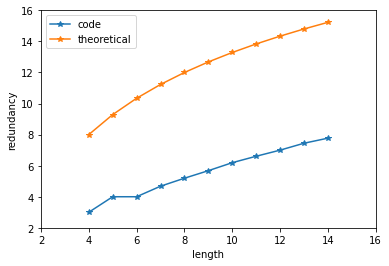

In [52]:
plt.plot(list(range(4,15)),redC,"*-")
plt.plot(list(range(4,15)),th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("redundancy")
plt.xlim(2,16)
plt.ylim(2,16)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

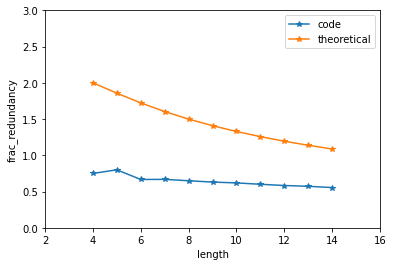

In [53]:
plt.plot(list(range(4,15)),frac_redC,"*-")
plt.plot(list(range(4,15)),frac_th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("frac_redundancy")
plt.xlim(2,16)
plt.ylim(0,3)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

In [ ]:
# code2 = open("code2", "wb")
# pickle.dump(C,code2)
# code2.close()

In [36]:
# code2 = pd.read_pickle("code2")

In [11]:
def del2(seq):
    if type(seq) != str:
        seq = list_to_str(seq)
    del_list = []
    for i in range(len(seq)):
        for j in range(i):
            temp = ""
            for k in range(len(seq)):
                if k!=i and k!=j:
                    temp += seq[k]
            del_list.append(temp)
    return list(set(del_list))

In [12]:
def i2d2_bal(sub_arr,card_Y,ins_ball_list,X,subseq):
    insbal = ins_ball_eval_fun(sub_arr,card_Y,ins_ball_list,X,bin_dec(subseq))
    i2d2 = []                             
    for i in range(card_Y):
        temp = del2(list_to_str(insbal[i]))
        for j in range(len(temp)):
            i2d2.append(temp[j])

    return list(set(i2d2))

In [13]:
def comp_i2d2_bal(i2d2bal_temp):
    c_i2d2_bal = []
    for i in range(len(i2d2bal_temp)):
        c_i2d2_bal.append(comp(i2d2bal_temp[i]))
    return c_i2d2_bal   

In [14]:
def comp(s):
    cs = ""
    for i in range(len(s)):
        cs += str((int(s[i])+1)%2)
    return cs 

In [15]:
def RLE(s):
    rs = ""
    temp = s[0]
    cnt = 0
    mr = 0 
    LEN = 0
    for i in range(0,len(s)):
        if s[i]==temp:
            cnt+=1
        else:
            rs += str(cnt)
            rs += ","
            LEN += 1
            mr = max(mr,cnt)
            cnt = 1
            temp = s[i]
    rs += str(cnt)
    mr = max(mr,cnt)
    return (s[0],rs,LEN+1,mr)

In [16]:
def greedy_code_RLE(n,m):
    sup_arr = bin_space_gen(n)
    sub_arr = bin_space_gen(m)

    X = MatrixSymbol('X', m+1, 2)

    card_Y = 0
    for i in range(0,n-m+1):
        card_Y += choose(n-1-i,m-1)*(2**(i))

    cnt = 0 
    nodes = deque([(0,n,m,-1,"root")])
    parent_stack = deque([0])
    n_temp = n
    m_temp = m
    parent = 0
    while parent_stack:
        add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, parent)
        add_node(nodes,parent_stack,"r",n_temp-1, m_temp, parent)
        parent_stack.popleft()

    ins_ball = [[]]
    cnt = 1 
    while cnt <len(nodes):
        temp = nodes[cnt]
        parent = temp[3]
        if(temp[4]=="l"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,0]])
        elif(temp[4]=="r"):
            ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,1]])
        cnt+=1

    ins_ball_list = []
    cnt = 0
    while cnt<len(nodes):
        temp = nodes[cnt]
        n_temp = temp[1]
        m_temp = temp[2]
        if(m_temp==0):
            bin_arr = bin_space_gen(n_temp)
            for i in range(len(bin_arr)):
                ins_ball_list.append(ins_ball[cnt]+list(bin_arr[i]))
        elif(n_temp==m_temp):
            temp = []
            for i in range(m_temp):
                temp.append(X[m-m_temp+1+i,0])
            ins_ball_list.append(ins_ball[cnt]+temp)
        cnt+=1 

    ent = []
    for s in range(0,int(len(sub_arr))):
        rle = RLE(sub_arr[s])
        ent.append((sub_arr[s],rle[1],rle[2],m-rle[3]))
    ent_sort = sorted(ent, key = operator.itemgetter(2,3))# ent_sort

    mark = np.zeros((len(ent_sort),1))
    CNT = 0 
    C = []
    for i in tqdm.tqdm(range(len(ent_sort))):
        subseq = ent_sort[i][0]
        c_subseq = comp(subseq)
        s = bin_dec(subseq)
        cs = bin_dec(c_subseq)
    
        if int(mark[s]) == 0:
            mark[s] = 1
            mark[cs] = 1
            cnt = 1 
            c_cnt = 1             
            i2d2bal = i2d2_bal(sub_arr,card_Y,ins_ball_list,X,subseq)
            c_i2d2bal = comp_i2d2_bal(i2d2bal)
            
            for j in range(len(i2d2bal)):
                if mark[bin_dec(i2d2bal[j])] == 0:
                    cnt += 1
                    mark[bin_dec(i2d2bal[j])] = 1 
                    
                if mark[bin_dec(c_i2d2bal[j])] == 0:                
                    c_cnt += 1
                    mark[bin_dec(c_i2d2bal[j])] = 1 
#             print(cnt,c_cnt)    
            C.append((subseq,cnt,len(i2d2bal)))
            C.append((c_subseq,c_cnt,len(i2d2bal)))
            CNT += cnt + c_cnt
            
    return C, CNT

In [34]:
m = 12
k = 2
C_12, CNT = greedy_code_RLE(m+k,m)

100%|██████████████████████████████████████| 4096/4096 [00:10<00:00, 392.48it/s]


In [35]:
C_12

[('000000000000', 79, 79),
 ('111111111111', 79, 79),
 ('000000000111', 163, 188),
 ('111111111000', 163, 188),
 ('000111111111', 150, 188),
 ('111000000000', 150, 188),
 ('000000111111', 136, 188),
 ('111111000000', 136, 188),
 ('000000111000', 236, 332),
 ('111111000111', 236, 332),
 ('000111000000', 206, 332),
 ('111000111111', 206, 332),
 ('000111111000', 160, 332),
 ('111000000111', 160, 332),
 ('001111000011', 219, 511),
 ('110000111100', 219, 511),
 ('001100111110', 224, 651),
 ('110011000001', 224, 651),
 ('011111001100', 171, 651),
 ('100000110011', 171, 651),
 ('000110001101', 138, 781),
 ('111001110010', 138, 781),
 ('010000001010', 68, 626),
 ('101111110101', 68, 626),
 ('001001010000', 58, 656),
 ('110110101111', 58, 656),
 ('000101101001', 34, 886),
 ('111010010110', 34, 886),
 ('010001010111', 6, 766),
 ('101110101000', 6, 766)]

In [36]:
 CNT

4096

In [57]:
bin_dec("1000")

8

In [40]:
def check_code(C):
    n = len(C[0])
    for i in tqdm.tqdm(range(len(C))):
        for j in range(i):
            if edit_dis(C[i],C[j],n,n) <= 2:
                print(C[i], C[j])
                return "INVALID"
    return "VALID"

In [104]:
k = 2
C = {}
for i in range(4,20):
    C[i] = greedy_code_RLE(i+k,i)

100%|██████████████████████████████████| 524288/524288 [33:25<00:00, 261.40it/s]


In [54]:
# k = 2
# C = {}
# for i in range(20,22):
#     C[i] = greedy_code_RLE(i+k,i)

In [31]:
for i in range(4,22):
    for j in range(len(C[i])):
        rle = RLE(C[i][j])
        temp = C[i][j]
        C[i][j] = (temp,rle[1],rle[2],rle[3])

In [16]:
RLE("000111000111")

('0', '3,3,3,3', 4, 3)

In [17]:
k = 2 
lenC = []
redC = []
frac_redC = []
th_redC = []
frac_th_redC = []
for i in range(4,22):
    lenC.append(len(C[i]))
    redC.append(i-math.log(len(C[i]),2))
    th_redC.append(k*math.log(i,2))
    frac_redC.append(1-(math.log(len(C[i]),2)/i))
    frac_th_redC.append((k*math.log(i,2))/i)

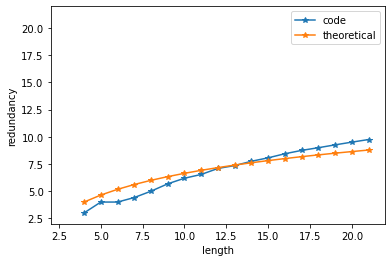

In [18]:
plt.plot(list(range(4,22)),redC,"*-")
plt.plot(list(range(4,22)),th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("redundancy")
plt.xlim(2,22)
plt.ylim(2,22)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

In [19]:
# r = 4 
# for n in [15,18,21]:
#     CNT = 0
#     for i in range(len(C[n])):
#         if C[n][i][2] == r:
#             CNT +=1 
#             print(C[n][i])
#     print(CNT)

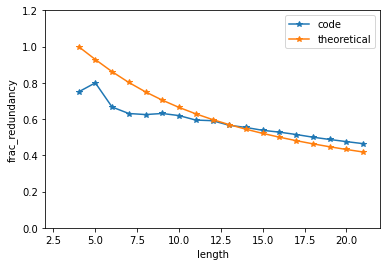

In [37]:
plt.plot(list(range(4,22)),frac_redC,"*-")
plt.plot(list(range(4,22)),frac_th_redC,"*-")
plt.legend(["code","theoretical"])
plt.xlabel("length")
plt.ylabel("frac_redundancy")
plt.xlim(2,22)
plt.ylim(0,1.2)
# plt.rcParams['figure.figsize'] = [7,7]
plt.show()

In [92]:
# code2 = open("code2", "wb")
# pickle.dump(C,code2)
# code2.close()

In [30]:
C = pd.read_pickle("code2") 

In [33]:
C[10]

[('0000000000', '10', 1, 10),
 ('1111111111', '10', 1, 10),
 ('0000000111', '7,3', 2, 7),
 ('1111111000', '7,3', 2, 7),
 ('0001111111', '3,7', 2, 7),
 ('1110000000', '3,7', 2, 7),
 ('0000111000', '4,3,3', 3, 4),
 ('1111000111', '4,3,3', 3, 4),
 ('0011000010', '2,2,4,1,1', 5, 4),
 ('1100111101', '2,2,4,1,1', 5, 4),
 ('0111100100', '1,4,2,1,2', 5, 4),
 ('1000011011', '1,4,2,1,2', 5, 4),
 ('0101101110', '1,1,1,2,1,3,1', 7, 3),
 ('1010010001', '1,1,1,2,1,3,1', 7, 3)]

In [15]:
C[15]

[('000000000000000', '15', 1, 15),
 ('111111111111111', '15', 1, 15),
 ('000000000000111', '12,3', 2, 12),
 ('111111111111000', '12,3', 2, 12),
 ('000111111111111', '3,12', 2, 12),
 ('111000000000000', '3,12', 2, 12),
 ('000000000111111', '9,6', 2, 9),
 ('111111111000000', '9,6', 2, 9),
 ('000000111111111', '6,9', 2, 9),
 ('111111000000000', '6,9', 2, 9),
 ('000000000111000', '9,3,3', 3, 9),
 ('111111111000111', '9,3,3', 3, 9),
 ('000111000000000', '3,3,9', 3, 9),
 ('111000111111111', '3,3,9', 3, 9),
 ('000111111111000', '3,9,3', 3, 9),
 ('111000000000111', '3,9,3', 3, 9),
 ('000000111000000', '6,3,6', 3, 6),
 ('111111000111111', '6,3,6', 3, 6),
 ('000000111111000', '6,6,3', 3, 6),
 ('111111000000111', '6,6,3', 3, 6),
 ('000111111000000', '3,6,6', 3, 6),
 ('111000000111111', '3,6,6', 3, 6),
 ('001111000000011', '2,4,7,2', 4, 7),
 ('110000111111100', '2,4,7,2', 4, 7),
 ('001111111000011', '2,7,4,2', 4, 7),
 ('110000000111100', '2,7,4,2', 4, 7),
 ('000000111000111', '6,3,3,3', 4, 6),
 ('

In [ ]:
def delta(r,s):
    if (r>s and s>=0):
        temp = 0 
        for i in range(s+1):
            temp += choose(r-s,i)
        return temp 
    elif (s == r and s>=0):
        return 1 
    else:
        return 0 
    
def U(s,n):
    temp =0 
    for r in range(3,n-s+1):
        tmp=0
        for i in range(s+r-(n-s)-1,min(s-2,r-3)+1):
            tmp+=delta(r-2,i)
        temp+= (2*choose(n-s-1,r-1))/(delta(r,s)+tmp)
    return temp

In [ ]:
U(n-m,m)

In [ ]:
2**(m-(n-m)*math.log(m,2))

In [ ]:
# Single deletion: VT code, upper bound - kullkarni 
len(C), (2**(m))/((m)+1), ((2**(m))-2)/((m)-1)

In [72]:
subseq = "01010101010"

In [77]:
m = len(subseq)
n = m + 2 
m

11

In [78]:
sup_arr = bin_space_gen(n)
sub_arr = bin_space_gen(m)

X = MatrixSymbol('X', m+1, 2)

card_Y = 0
for i in range(0,n-m+1):
    card_Y += choose(n-1-i,m-1)*(2**(i))

cnt = 0 
nodes = deque([(0,n,m,-1,"root")])
parent_stack = deque([0])
n_temp = n
m_temp = m
parent = 0
while parent_stack:
    add_node(nodes,parent_stack,"l",n_temp-1, m_temp-1, parent)
    add_node(nodes,parent_stack,"r",n_temp-1, m_temp, parent)
    parent_stack.popleft()

ins_ball = [[]]
cnt = 1 
while cnt <len(nodes):
    temp = nodes[cnt]
    parent = temp[3]
    if(temp[4]=="l"):
        ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,0]])
    elif(temp[4]=="r"):
        ins_ball.append(ins_ball[parent]+[X[m-(nodes[parent][2])+1,1]])
    cnt+=1

ins_ball_list = []
cnt = 0
while cnt<len(nodes):
    temp = nodes[cnt]
    n_temp = temp[1]
    m_temp = temp[2]
    if(m_temp==0):
        bin_arr = bin_space_gen(n_temp)
        for i in range(len(bin_arr)):
            ins_ball_list.append(ins_ball[cnt]+list(bin_arr[i]))
    elif(n_temp==m_temp):
        temp = []
        for i in range(m_temp):
            temp.append(X[m-m_temp+1+i,0])
        ins_ball_list.append(ins_ball[cnt]+temp)
    cnt+=1 

In [79]:
i2d2bal = i2d2_bal(sub_arr,card_Y,ins_ball_list,X,subseq)
c_i2d2bal = comp_i2d2_bal(i2d2bal)

In [80]:
len(i2d2bal)

562